In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import poisson

# repress warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
# The transmission channel in this case is effect of carbon tax on cost (reflectected in EBITDA) - effect on credit score - effect on PD.
# No passthrough, interdepency or anything is assumed! Simple toy model. 

Generate synthetic data

In [14]:
# Seed for reproducibility
np.random.seed(42)

# Generate Synthetic Data
n_samples = 10000
annual_revenue = np.random.lognormal(mean=10, sigma=2, size=n_samples)
ebitda_margin = np.random.uniform(0.1, 0.5, n_samples) 
debt_to_equity_ratio = np.random.uniform(0.1, 2.0, n_samples)
credit_utilization_ratio = np.random.uniform(0.0, 1.0, n_samples)
years_in_business = np.random.randint(1, 100, n_samples)
dti_ratios = np.random.uniform(0, 1, n_samples)
age_of_credit_history = np.random.randint(1, 30, n_samples)
emissions = np.random.uniform(0, 100, n_samples)

# Simplified synthetic credit score: A linear combination of features plus some noise
credit_scores = (
    800 -  # Base score
    2 * debt_to_equity_ratio -
    150 * credit_utilization_ratio +
    3 * ebitda_margin * 100 +
    np.log(annual_revenue) * 20 +
    years_in_business + 
    np.random.normal(0, 50, n_samples)
)

data = pd.DataFrame({
    'Annual_Revenue': annual_revenue,
    'EBITDA_Margin': ebitda_margin,
    'Debt_to_Equity_Ratio': debt_to_equity_ratio,
    'Credit_Utilization_Ratio': credit_utilization_ratio,
    'Years_in_Business': years_in_business,
    'Credit_Score': credit_scores,
    'DTI_Ratio': dti_ratios,
    'Age_of_Credit_History': age_of_credit_history,
    'Emissions': emissions
})

# Prepare Data for Modeling the Credit Scores
X = data.drop('Credit_Score', axis=1)
y = data['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression Model
credit_model = LinearRegression()
credit_model.fit(X_train, y_train)

# Predictions
predictions_credit_model = credit_model.predict(X_test)

# Evaluation
print("R^2 Score:", r2_score(y_test, predictions_credit_model))
print("Mean Squared Error:", mean_squared_error(y_test, predictions_credit_model))

R^2 Score: 0.5280606044562828
Mean Squared Error: 3703.12092267932


In [15]:
# print X data
print(X)

      Annual_Revenue  EBITDA_Margin  Debt_to_Equity_Ratio  \
0       59481.957248       0.228502              0.425869   
1       16705.134357       0.141208              0.758924   
2       80448.867576       0.128723              1.943193   
3      463267.404013       0.137710              1.583497   
4       13789.921118       0.333148              0.636923   
...              ...            ...                   ...   
9995   297212.938653       0.373175              0.821913   
9996      404.766382       0.439965              1.226554   
9997     5374.208316       0.186289              1.376240   
9998    59369.217435       0.401531              1.325823   
9999    79919.639862       0.452542              1.740205   

      Credit_Utilization_Ratio  Years_in_Business  DTI_Ratio  \
0                     0.218757                  2   0.646347   
1                     0.636746                 75   0.034141   
2                     0.101114                 33   0.067465   
3          

In [16]:
# Calculate ebitda
data['ebitda'] = data['Annual_Revenue'] * data['EBITDA_Margin']

Generate synthetic PD model

In [17]:
# Data Generation
np.random.seed(0)
n_samples = 10000
credit_scores = np.random.randint(300, 850, n_samples)
dti_ratios = np.random.uniform(0, 1, n_samples)
age_of_credit_history = np.random.randint(1, 30, n_samples)
defaults = np.random.binomial(1, p=0.2, size=n_samples)  # Assume 20% baseline default rate

data_PD_model = pd.DataFrame({
    'Credit_Score': credit_scores,
    'DTI_Ratio': dti_ratios,
    'Age_of_Credit_History': age_of_credit_history,
    'Default': defaults
})

# Model Training
X = data_PD_model[['Credit_Score', 'DTI_Ratio', 'Age_of_Credit_History']]
y = data_PD_model['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

PD_model = LogisticRegression(solver='liblinear')
PD_model.fit(X_train, y_train)

# Step 3: Prediction & Evaluation
PD_predictions = PD_model.predict(X_test)
PD_probabilities = PD_model.predict_proba(X_test)[:, 1]

print("Model Accuracy:", accuracy_score(y_test, PD_predictions))
print("ROC AUC Score:", roc_auc_score(y_test, PD_probabilities))


Model Accuracy: 0.8005
ROC AUC Score: 0.5082913404685981


In [18]:
# print X data
print(X)

      Credit_Score  DTI_Ratio  Age_of_Credit_History
0              492   0.657822                      2
1              659   0.850048                      2
2              309   0.404118                     26
3              577   0.179487                     19
4              370   0.704715                      2
...            ...        ...                    ...
9995           844   0.211341                      5
9996           461   0.847556                      9
9997           795   0.611679                      8
9998           726   0.787945                     10
9999           581   0.583096                     27

[10000 rows x 3 columns]


In [19]:
# get prediction for a new customer
new_customer = pd.DataFrame({
    'Credit_Score': [600],
    'DTI_Ratio': [0.3],
    'Age_of_Credit_History': [5]
})

print("New Customer Probability of Default:", PD_model.predict_proba(new_customer)[:, 1])

New Customer Probability of Default: [0.21418374]


In [20]:
# print model coefficients
print("Model Coefficients:", PD_model.coef_)

Model Coefficients: [[-0.00017133 -0.15227163 -0.00698393]]


Predict effect of carbon tax on PD

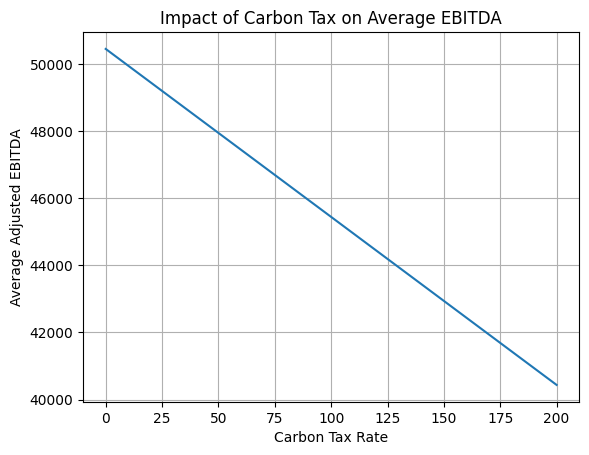

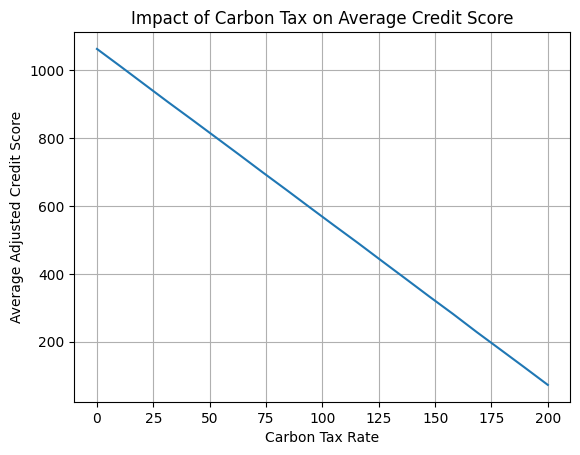

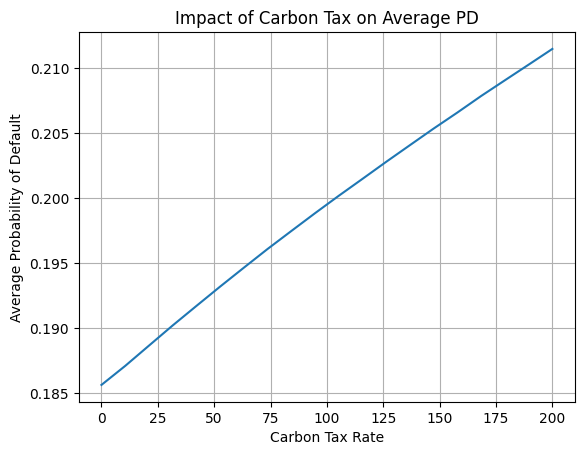

In [21]:
# Define a function to adjust EBITDA based on carbon tax and recalculate credit scores
def adjust_ebitda_and_credit_score(data, carbon_tax_rate):
    # Adjust EBITDA Margin by simulating the impact of carbon tax
    # Assuming carbon tax directly reduces EBITDA margin as a simplified model
    data['Adjusted_EBITDA'] = data['ebitda'] - (carbon_tax_rate * data['Emissions'])
    
    # Recalculate credit scores considering the adjusted EBITDA
    data['Adjusted_Credit_Score'] = (
        800 -
        2 * data['Debt_to_Equity_Ratio'] -
        150 * data['Credit_Utilization_Ratio'] +
        3 * (data['Adjusted_EBITDA'] / data['Annual_Revenue']) * 100 +  # Recalculate margin
        np.log(data['Annual_Revenue']) * 20 +
        data['Years_in_Business'] +
        np.random.normal(0, 50, len(data))
    )
    
    return data

# Define carbon tax rates
carbon_tax_rates = np.linspace(0, 200, 20) # here, we would put in the outputs of Kainth et al. (2024) with real distributions (see next cell for example) and climate damages in accordance with pathways (using different time dynamics - model outputs for scenario analysis, frontloading for stress testing, etc.)

avg_adjusted_ebitda = []
avg_adjusted_credit_scores = []
avg_default_probs = []





# Here lies our main contribution:

#   |
#   |
#   |
#   |
#   |
#   V

# Our contribution lies in defining the transmission channels and (maybe holy grail) the impact functions (otherwise we runs sensitivity analysis on the impact functions)
# Research question: how to change these inputs? What can we learn from the data?
    

# Calculate and store average PD for each carbon tax rate
for rate in carbon_tax_rates:
    adjusted_data = adjust_ebitda_and_credit_score(data.copy(), rate)
    adjusted_X = adjusted_data[['Adjusted_Credit_Score', 'DTI_Ratio', 'Age_of_Credit_History']] # <-- mainly this step is the main contribution (obviously, this will be more sophisticated in reality, but this is the basic idea) 
    adjusted_probs = PD_model.predict_proba(adjusted_X)[:, 1]
    avg_default_probs.append(np.mean(adjusted_probs))
    avg_adjusted_ebitda.append(adjusted_data['Adjusted_EBITDA'].mean())
    avg_adjusted_credit_scores.append(adjusted_data['Adjusted_Credit_Score'].mean())





# Plotting
plt.plot(carbon_tax_rates, avg_adjusted_ebitda)
plt.xlabel('Carbon Tax Rate')
plt.ylabel('Average Adjusted EBITDA')
plt.title('Impact of Carbon Tax on Average EBITDA')
plt.grid(True)
plt.show()

plt.plot(carbon_tax_rates, avg_adjusted_credit_scores)
plt.xlabel('Carbon Tax Rate')
plt.ylabel('Average Adjusted Credit Score')
plt.title('Impact of Carbon Tax on Average Credit Score')
plt.grid(True)
plt.show()

plt.plot(carbon_tax_rates, avg_default_probs)
plt.xlabel('Carbon Tax Rate')
plt.ylabel('Average Probability of Default')
plt.title('Impact of Carbon Tax on Average PD')
plt.grid(True)
plt.show()




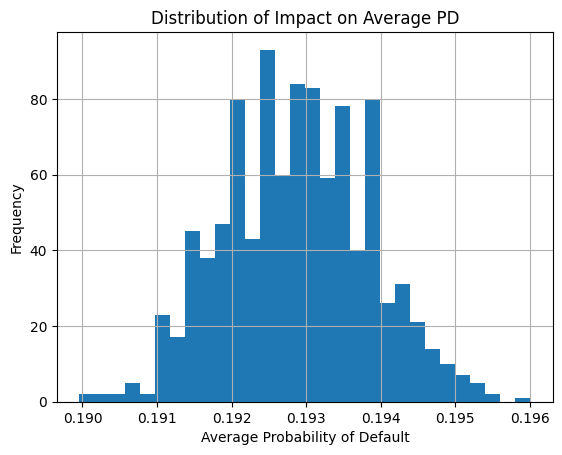

In [22]:
# Calculate the impact of carbon tax on the average probability of default given a Poisson distribution of carbon tax rates
# We are using a Poisson distribution to model the frequency of different carbon tax rates
# This is a simplified example to illustrate the concept of distributional impact analysis
# In practice, we would use a distribution of carbon tax rates based on model outputs by Kainth et al. (2024)
carbon_tax_distribution = poisson(50)  # Average tax rate of 50
n_samples = 1000
sampled_tax_rates = carbon_tax_distribution.rvs(n_samples)

# Calculate and store average PD for each sampled carbon tax rate
sampled_avg_default_probs = []
for rate in sampled_tax_rates:
    adjusted_data = adjust_ebitda_and_credit_score(data.copy(), rate)
    adjusted_X = adjusted_data[['Adjusted_Credit_Score', 'DTI_Ratio', 'Age_of_Credit_History']]
    adjusted_probs = PD_model.predict_proba(adjusted_X)[:, 1]
    sampled_avg_default_probs.append(np.mean(adjusted_probs))

# Plotting
plt.hist(sampled_avg_default_probs, bins=30)
plt.xlabel('Average Probability of Default')
plt.ylabel('Frequency')
plt.title('Distribution of Impact on Average PD')
plt.grid(True)
plt.show()